In [1]:
import sys 
import os
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import astropy.constants as c
import astropy.units as u
from astropy.io import fits
from IPython.display import display
import logging
from pathlib import Path
from datetime import datetime
import pyregion
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.coordinates import SkyCoord
import importlib
import pickle
import pandas as pd
try:
    logging.getLogger('matplotlib').disabled = True
except:
    pass
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)
import shutil
from astropy.table import QTable, Table
from matplotlib.patches import (Ellipse, Rectangle)
import matplotlib.patches as mpatches
import itertools
import shapely
import shapely.plotting
from shapely.geometry.point import Point
from shapely import affinity
from scipy.integrate import dblquad
from uncertainties import ufloat
from scipy.optimize import curve_fit
from astropy.visualization import (
    MinMaxInterval, 
    SqrtStretch,
    ImageNormalize,
    simple_norm
)
from astropy import visualization
import matplotlib.cm as cm
from pprint import pprint
import pylustrator
from astropy.stats import sigma_clipped_stats
from astropy.modeling import models
from astropy.convolution.kernels import CustomKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.utils._parameters import as_pair
from astropy.convolution import discretize_model
from pathlib import Path

In [2]:
ROOT_DIR = os.path.dirname(os.path.realpath('__file__'))
PROG_DIR = os.path.abspath('./mirar')
os.chdir(PROG_DIR)

In [3]:
class Fits:
    def __init__(self, file, print_=True):
        self.file = file
        self.data = {}
        self.header = {}
        open_file = fits.open(self.file)
        if print_:
            open_file.info()
        open_file.close()
        self.read()
        try:
            logging.getLogger("matplotlib").disabled = True
        except:
            pass

    def read(self, hdu=0):
        open_file = fits.open(self.file)
        try:
            self.data[hdu] = open_file[hdu].data.astype(float)
        except (AttributeError, TypeError, ValueError):
            print(rf"HDU {hdu} is not float")
            self.data[hdu] = open_file[hdu].data

        self.header[hdu] = open_file[hdu].header
        open_file.close()

    def wcs_plot(self, hdu=0):
        wcs = WCS(self.header[hdu])
        fig = plt.figure(clear=True)
        ax = plt.subplot(projection=wcs)
        fig.add_axes(ax)
        return fig, ax

    def create_copy(self):
        shutil.copy2(self.file, f"{self.file}.copy")

    def image(
        self,
        hdu=0,
        column=False,
        title=None,
        scale=[5, 95],
        save=False,
        tag=None,
        wcs=False,
        median=True,
        meanstd=True,
    ):
        data = self.data[hdu]
        if column:
            data = data[column]
        if not wcs:
            fig, ax = plt.subplots()
            ax.set_xlabel("x pixel")
            ax.set_ylabel("y pixel")
        else:
            wcs_ = WCS(self.header[hdu])
            fig = plt.figure(clear=True)
            ax = plt.subplot(projection=wcs_)
            fig.add_axes(ax)
        self.ax = ax
        if not meanstd and scale:
            try:
                if median:
                    img = np.nanmedian(data, axis=1)
                else:
                    img = data
            except np.AxisError:
                print("invalid shape", data.shape)
                return
            self.scale_low, self.scale_high = np.percentile(img, scale)
            im = ax.imshow(
                data, cmap="magma", vmin=self.scale_low, vmax=self.scale_high
            )
        elif meanstd:
            mean, std = np.nanmean(data), np.nanstd(data)
            vmin = mean - std
            vmax = mean + 10 * std
            im = ax.imshow(
                data,
                interpolation="nearest",
                cmap="grey",
                vmin=vmin,
                vmax=vmax,
                origin="lower",
                # norm=mcolors.Normalize(vmin=vmin,vmax=vmax)
            )
        else:
            im = ax.imshow(data, cmap="magma")
        fig.colorbar(im, ax=ax , pad=0.005)
        if not title:
            title = rf"{os.path.basename(os.path.dirname(self.file))}/{os.path.basename(self.file)}"
        ax.set_title(title)
        if save:
            if tag:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}_{tag}.png",
                    ),
                    dpi=600,
                )
            else:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}.png",
                    ),
                    dpi=600,
                )
        fig.tight_layout()
        return ax

    def image_with_reg(
        self, reg, hdu=0, wcsaxis=[0.1, 0.1, 0.8, 0.8], v=[0, 100], save=False, tag=None
    ):
        r = pyregion.open(reg).as_imagecoord(self.header[hdu])
        patch_list, artist_list = r.get_mpl_patches_texts()
        wcs = WCS(self.header[hdu])
        fig = plt.figure(clear=True)
        ax = plt.subplot(projection=wcs)
        # ax = WCSAxes(fig,wcsaxis,wcs=wcs)
        fig.add_axes(ax)
        for p in patch_list:
            p.set_color("red")
            p.set_facecolor("none")
            ax.add_patch(p)
        for t in artist_list:
            ax.add_artist(t)

        if v:
            im = ax.imshow(
                self.data[0], origin="lower", vmin=v[0], vmax=v[1], cmap="magma"
            )
        else:
            im = ax.imshow(self.data[0], origin="lower", cmap="magma")
        fig.colorbar(im, cmap="magma")
        if save:
            if tag:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}_{tag}.reg.png",
                    ),
                    dpi=600,
                )
            else:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}.reg.png",
                    ),
                    dpi=600,
                )
        # fig.show()
        return ax

    def bin_table(self, hdu=0, return_=True, save=False):
        df = pd.DataFrame(self.data[hdu])
        if save:
            df.to_csv(
                os.path.join(
                    os.path.dirname(self.file), rf"{os.path.basename(self.file)}.csv"
                ),
                encoding="utf-8",
            )
        if return_:
            return df
        else:
            return None

    def bin_table2(self, hdu=0):
        table = QTable(self.data[hdu])
        return table

    def mark_from_cat(self, keys, cat_file=None, cat_table=None, hdu=2, save=False, color='red'):
        x_offset = 2
        y_offset = 2
        if cat_file:
            catfits = Fits(cat_file)
            catfits.read(hdu)
            cat = catfits.bin_table2(hdu)
        elif isinstance(cat_table,QTable) or isinstance(cat_table,pd.DataFrame):
            cat = cat_table
        else:
            return
        shape = (self.ax.get_xlim()[-1], self.ax.get_ylim()[-1])
        for i, (x, y, a, b, theta) in enumerate(
            zip(
                cat[keys["x"]],
                cat[keys["y"]],
                cat[keys["a"]],
                cat[keys["b"]],
                cat[keys["angle"]],
            )
        ):
            marker = Ellipse(xy=(x,y), height=a, width=b, angle=theta-90, color=color, fill=None) # theta-90 to rotate wrt. x
            self.ax.add_patch(marker)
            annotation = str(i)
            try:
                if 'NUMBER' in list(cat.columns):
                    annotation = cat['NUMBER'][i]
            except:
                print('could not access column names')
            if x + x_offset >= shape[0] - x_offset * 2:
                self.ax.annotate(
                    annotation, (x - x_offset*2, y + y_offset), color=color
                )
            else:
                self.ax.annotate(annotation, (x + x_offset, y + y_offset), color=color)
        if save:
            plt.savefig(cat_file+'.png',dpi=300)

SEX_SRC_KEYS = {
    'x': 'X_IMAGE',
    'y': 'Y_IMAGE',
    'a': 'A_IMAGE',
    'b': 'B_IMAGE',
    'angle': 'THETA_IMAGE'
}

MIRAR_SRC_KEYS = {
    'x': 'xpos',
    'y': 'ypos',
    'a': 'aimage',
    'b': 'bimage',
    'angle': 'THETA_IMAGE'
}

PSF_PHOT_SRC_KEYS = {
    'x': 'x_fit',
    'y': 'y_fit',
    'a': 'a',
    'b': 'b',
    'angle': 'angle'
}

class MakeFits:
    def __init__(self, data, filename, obsclass="science", **kwargs):
        self.data = data
        self.filename = filename
        self.obsclass = obsclass

        hdu0 = fits.PrimaryHDU(data)
        self.hdul = fits.HDUList([hdu0])
        self.hdul.verify("fix")
        self.fix_header()
        self.save(**kwargs)

    def fix_header(self):
        header = self.hdul[0].header
        header[OBSCLASS_KEY] = self.obsclass
        header[TARGET_KEY] = self.obsclass
        header[TIME_KEY] = str(datetime.now())
        header[COADD_KEY] = 1
        header[GAIN_KEY] = 1
        header[PROC_HISTORY_KEY] = ""
        header[PROC_FAIL_KEY] = ""
        header[BASE_NAME_KEY] = Path(self.filename).name

    def save(self, **kwargs):
        self.hdul.writeto(self.filename, **kwargs)


def src_table(file, save=False, return_=True):
    df = pd.read_pickle(file).get_data()
    if save:
        df.to_csv(
            os.path.join(os.path.dirname(file), rf"{os.path.basename(file)}.csv"),
            encoding="utf-8",
        )
    if return_:
        return df
    else:
        return None


class Convert:
    def __init__(self, ra, dec):
        self.coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)

    def get_coords(self):
        return self.coords

    def to_hms(self):
        return (self.coords.ra.hms, self.coords.dec.hms)

    def to_wcs(self):
        return (self.coords.ra.hms, self.coords.dec.dms)


def command(config, py=""):
    return rf"python{py} -m mirar -p {PIPELINE} -n {NIGHT} -c {config} -m"


def run(config, *args, **kwargs):
    os.system(command(config, *args, **kwargs))

def get_prams():
    return _ih[-1]

def save_prams(path):
    with open(path,'w') as file:
        file.write(get_prams())

def test(py=""):
    os.system(rf"python{py} -m unittest discover tests/")

def plot_image(ax,data,cmap='grey',scale=True,colorbar=True):
    mean, std = np.nanmean(data), np.nanstd(data)
    if scale:
        vmin = mean - std
        vmax = mean + 10 * std
    else:
        vmin = vmax = None
    im = ax.imshow(
        data,
        interpolation="nearest",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        origin="lower",
    )
    if colorbar:
        ax.get_figure().colorbar(im, ax=ax , pad=0.005)
    return im

def peek(ax,coords,size):
    ax.set_xlim([coords[0]-size//2,coords[0]+size//2])
    ax.set_ylim([coords[1]-size//2,coords[1]+size//2])
  
def get_pos(table,obj,keys):
    row = table[obj-1]
    x = row[keys['x']]
    y = row[keys['y']]
    return np.array([float(x),float(y)])

def mark_from_cat(ax, keys, cat_file=None, cat_table=None, hdu=2, save=False, color='red', condition=True,bound=False,bounds=None,annotate=True):
    x_offset = 2
    y_offset = 2
    if cat_file:
        catfits = Fits(cat_file)
        catfits.read(hdu)
        cat = catfits.bin_table2(hdu)
    elif isinstance(cat_table,QTable) or isinstance(cat_table,pd.DataFrame):
        cat = cat_table
    else:
        return
    shape = (ax.get_xlim()[-1], ax.get_ylim()[-1])
    
    pos_all = []
    for i, (x, y, a, b, theta) in enumerate(
        zip(
            cat[keys["x"]],
            cat[keys["y"]],
            cat[keys["a"]],
            cat[keys["b"]],
            cat[keys["angle"]],
        )
    ):
        if condition:
            if not bound or bound and (x>=bounds[0][0] and x<=bounds[0][1] and y>=bounds[1][0] and y<=bounds[1][1]):
                marker = Ellipse(xy=(x,y), height=a, width=b, angle=theta-90, color=color, fill=None) # theta-90 to rotate wrt. x
                ax.add_patch(marker)
                annotation = str(i)
                if annotate:
                    try:
                        if 'NUMBER' in list(cat.columns):
                            annotation = cat['NUMBER'][i]
                    except:
                        print('could not access column names')
                    if x + x_offset >= shape[0] - x_offset * 2:
                        ax.annotate(
                            annotation, (x - x_offset*2, y + y_offset), color=color
                        )
                    else:
                        ax.annotate(annotation, (x + x_offset, y + y_offset), color=color)
                pos_all.append([x,y])
    return pos_all
       
 
def none_mask(lst):
    for i in range(len(lst)):
        if lst[i] == None:
            lst[i] = np.nan
    return lst

In [4]:
def test_path(name):
    if isinstance(name,tuple):
        return Path(os.path.abspath(os.path.join(TEST_DIR,*name)))
    else:
        return Path(os.path.abspath(os.path.join(TEST_DIR,name)))
    
def make_test_dirs():
    for dir in OUTPUT_DIRS.values():
        os.makedirs(dir, exist_ok=True)
        
def move_to_raw(path):
    path = Path(path)
    dst = os.path.join(RAW_DIR,path.name)
    shutil.copyfile(path,dst)
    
def prepare(src_dir,src_basenames):
    for file in os.listdir(src_dir):
        for basename in src_basenames:
            if basename in file:
                move_to_raw(os.path.join(src_dir,file)) 
                
def save_params(path):
    with open(path,'w') as file:
        file.write(_ih[-1])
        
DATA_DIR = os.path.join(ROOT_DIR,'SampleData')

TEST_ID = '0'
TEST_DIR = os.path.abspath(os.path.join(ROOT_DIR,'test_'+TEST_ID))
OUTPUT_DIRS = {
    'BKG': test_path('background'),
    'DET': test_path('detection'),
    'PSF_MODEL': test_path('psf_model'),
    'PSF_PHOT': test_path('psf_phot'),
    'APER_PHOT': test_path('aper_phot'),
    'LOG': test_path('log'),
    'CONF': test_path('config'),
    'RES': test_path('results'),
    'CAT': test_path('catalogs'),
}
make_test_dirs()

RAW_DIR = os.path.join(TEST_DIR,'raw')
os.makedirs(RAW_DIR, exist_ok=True)

LOGGING = True
LOG_FILE = os.path.abspath(os.path.join(OUTPUT_DIRS['LOG'],f"test{TEST_ID}_{datetime.now()}"))
if LOGGING:
    logger = logging.getLogger(__name__)
    logging.basicConfig(filename=LOG_FILE,level=logging.DEBUG)
    logging.getLogger('matplotlib').disabled = True

ENV = {
    'RAW_DATA_DIR': RAW_DIR,
    'OUTPUT_DATA_DIR': TEST_DIR,
    'REF_IMG_DIR': '',
    'USE_WINTER_CACHE': 'false',
    'FRITZ_TOKEN': 'test',
    'KOWALSKI_TOKEN': 'test',
    'DB_USER': 'postgres',
    'DB_PWD': '',
}
for var in ENV.keys():
    os.environ[var] = ENV[var]

In [40]:
# mirar
from mirar.pipelines.wifes_autoguider.wifes_autoguider_pipeline import WifesAutoguiderPipeline
from mirar.processors.astromatic.sextractor.background_subtractor import (
    SextractorBkgSubtractor,
)
from mirar.processors.astromatic.sextractor.sextractor import Sextractor
from mirar.processors.utils import (
    CustomImageBatchModifier,
    HeaderAnnotator,
    ImageBatcher,
    ImageDebatcher,
    ImageLoader,
    ImageSaver,
    ImageSelector,
    MEFLoader,
)
from mirar.processors.utils.header_annotate import (
    HeaderEditor,
    # SextractorHeaderCorrector,
)
from mirar.data import (
    Image,
    Dataset, 
    ImageBatch,
    SourceBatch,
    SourceTable
)
from mirar.io import open_raw_image
from mirar.paths import (
    BASE_NAME_KEY,
    COADD_KEY,
    GAIN_KEY,
    LATEST_SAVE_KEY,
    LATEST_WEIGHT_SAVE_KEY,
    OBSCLASS_KEY,
    PROC_FAIL_KEY,
    PROC_HISTORY_KEY,
    RAW_IMG_KEY,
    SATURATE_KEY,
    TARGET_KEY,
    TIME_KEY,
    DIFF_IMG_KEY,
    REF_IMG_KEY,
    SCI_IMG_KEY,
    XPOS_KEY,
    YPOS_KEY,
    NORM_PSFEX_KEY,
    core_fields,
    get_output_dir
)
from mirar.processors.astromatic import PSFex, Scamp
# from mirar.processors.photometry.psf_photometry import SourcePSFPhotometry
# from mirar.processors.photometry.aperture_photometry import SourceAperturePhotometry
from mirar.processors.sources import (
    SourceWriter
)
# from mirar.processors.sources.source_detector import (
#     SourceGenerator
# )
from mirar.processors.base_processor import (
    BaseImageProcessor,
    BaseSourceProcessor,
    BaseSourceGenerator,
)
# from mirar.processors.photometry.base_photometry import (
#     BaseSourcePhotometry,
# )
from mirar.utils.pipeline_visualisation import flowify
from mirar.io import (
    open_fits,
    save_to_path
)
from mirar.processors.base_processor import PrerequisiteError
from mirar.processors.utils.image_selector import select_from_images
from mirar.processors.photcal import PhotCalibrator
from mirar.utils.ldac_tools import (
    save_table_as_ldac,
    get_table_from_ldac
)
from mirar.processors.astromatic.sextractor.sextractor import SEXTRACTOR_HEADER_KEY
from mirar.catalog.base_catalog import CatalogFromFile
from mirar.catalog.vizier.gaia import Gaia
from mirar.catalog.vizier.base_vizier_catalog import VizierCatalog

# photutils
from photutils.background import Background2D
from photutils.detection import DAOStarFinder
from photutils.psf import extract_stars
from photutils.psf import EPSFBuilder

import astropy
from photutils.background.interpolators import BkgZoomInterpolator
from photutils.background import Background2D
from photutils.background.core import (
    SExtractorBackground,
    StdBackgroundRMS
)
from astropy.nddata import NDData
from astropy.stats import SigmaClip
from typing import Callable
from astropy.convolution import convolve
from astropy.convolution import (
    Kernel,
    CustomKernel,
)
from photutils.segmentation import (
    make_2dgaussian_kernel,
    SourceFinder,
    SourceCatalog
)
from astropy.wcs import WCS

In [74]:
ACQ_KEY = 'acq'
BGMED_KEY = 'BGMED'
BGRMSMED_KEY = 'BGRMSMED'
SEGMPATH_KEY = 'SEGMPATH'
CONVPATH_KEY = 'CONVPATH'
BGPATH_KEY = 'BGPATH'
SEGMOBJ_KEY = 'SEGMOBJ'
PSF_CUTOUTS_PATH_KEY = 'PCUTPATH'
PSF_CUTOUTS_SIZE_KEY = 'PCUTSIZE'
NPSFPATH_KEY = 'NPSFPATH'

sex_all_ground = CustomKernel(np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
]))

def default_select_acquisition(
    images: ImageBatch,
) -> ImageBatch:
    """
    Returns images in a batch with are tagged as error

    :param images: set of images
    :return: subset of bias images
    """
    return select_from_images(images, key=OBSCLASS_KEY, target_values=ACQ_KEY)

def load_object(path):
    with open(path,'rb') as file:
        return pickle.load(file)
    
def dump_object(data,path):
    with open(path,'wb') as file:
        return pickle.dump(data,file)

class WifesAutoguiderVisier:
    
    def __init__(
        self,
        visier_catalog: VizierCatalog,
        cache: bool = False,
    ):
        self.visier_catalog = visier_catalog
        self.cache = cache
        
    def generator(
        self,
        image: Image,
    ) -> VizierCatalog | CatalogFromFile:
        
        filter_name = image["FILTER"]

        search_radius_arcmin = (
            np.max([image["NAXIS1"], image["NAXIS2"]])
            * np.max([np.abs(image["CD1_1"]), np.abs(image["CD1_2"])])
            * 60
        ) / 2.0
        
        # TODO: match closest
        if filter_name == 'I':
            filter_name = 'RP'

        return self.visier_catalog(
            min_mag=10,
            max_mag=20,
            search_radius_arcmin=search_radius_arcmin,
            filter_name=filter_name,
            cache_catalog_locally=self.cache,
        )
    
def wifes_autoguider_photometric_catalog_purifier(
    
) -> Table:
    return 

class PhotutilsBkgSubtractor(BaseImageProcessor):
    
    base_key = "photutilsbkgsubtractor"
    
    def __init__(
        self,
        box_size = 40,
        mask=None, 
        coverage_mask=None, 
        fill_value=0.0, 
        exclude_percentile=10.0, 
        filter_size=(3, 3), 
        filter_threshold=None, 
        edge_method='pad', 
        sigma_clip=SigmaClip(
            sigma=3.0, 
            sigma_lower=3.0, 
            sigma_upper=3.0,
            maxiters=10, 
            cenfunc='median', 
            stdfunc='std', 
            grow=False
        ), 
        bkg_estimator=SExtractorBackground(sigma_clip=None), 
        bkgrms_estimator=StdBackgroundRMS(sigma_clip=None),
        interpolator=BkgZoomInterpolator(),
        output_sub_dir = 'background',
        select_images: Callable[[ImageBatch], ImageBatch] = default_select_acquisition, #change
        dev: bool = False,
        cache: bool = False,
    ):
        super().__init__()
        self.box_size = box_size
        self.mask = mask
        self.coverage_mask = coverage_mask
        self.fill_value = fill_value
        self.exclude_percentile = exclude_percentile
        self.filter_size = filter_size
        self.filter_threshold = filter_threshold
        self.edge_method = edge_method
        self.sigma_clip = sigma_clip
        self.bkg_estimator = bkg_estimator
        self.bkgrms_estimator = bkgrms_estimator
        self.interpolator = interpolator
        self.cache = cache
        self.output_sub_dir = output_sub_dir
        self.dev = dev
        self.select_images = select_images
    
    def _apply_to_images(
        self,
        batch: ImageBatch,
    ) -> ImageBatch:
        
        images = self.select_images(batch)
        
        for image in images:
            data = image.get_data()
            header = image.get_header()
            background = Background2D(
                data=data,
                box_size=self.box_size,
                mask = self.mask,
                coverage_mask = self.coverage_mask,
                fill_value = self.fill_value,
                exclude_percentile = self.exclude_percentile,
                filter_size = self.filter_size,
                filter_threshold = self.filter_threshold,
                edge_method = self.edge_method,
                sigma_clip = self.sigma_clip,
                bkg_estimator = self.bkg_estimator,
                bkgrms_estimator = self.bkgrms_estimator,
                interpolator = self.interpolator
            )
            background_map = background.background
            
            header[BGMED_KEY] = background.background_median
            header[BGRMSMED_KEY] = background.background_rms_median
            
            bkgsub = data - background_map
            image.set_data(bkgsub)
            
            save_images = []
            output_dir = get_output_dir(self.output_sub_dir, self.night_sub_dir)
            
            if self.cache:
                save_images = ['background']
                # bkg_image_name = image[BASE_NAME_KEY].replace('fits','background.fits')
                bkg_image_name = image[BASE_NAME_KEY]+'.background'
                header[BGPATH_KEY] = str(output_dir.joinpath(bkg_image_name))
                
            if self.dev:
                save_images += ['background','background_rms','background_mesh','background_rms_mesh']
                save_name = image[BASE_NAME_KEY].replace('fits','background.pkl')
                dump_object(
                    data=background,
                    path=output_dir.joinpath(save_name)
                )
                
            for im in save_images:
                # save_name = image[BASE_NAME_KEY].replace('fits',im+'.fits')
                save_name = image[BASE_NAME_KEY]+f".{im}"
                save_to_path(
                    data=eval('background.'+im),
                    header=image.header,
                    path=output_dir.joinpath(save_name),
                    overwrite=True
                )
            
            image.set_header(header)
        
        return batch

class PhotutilsSourceFinder(BaseImageProcessor):
    """
    Processor to detect sources using photutils.segmentation.SourceFinder
    
    Args
        convolution_fwhm: FWHM of convolution mask
        convolution_kernel_size: size of convolution kernel
        npixels: number of connected pixels for detection
        threshold_factor: threshold factor of background RMS median
        connectivity: {4,8} source pixel grouping
        deblend: Whether to deblend overlapping sources.
        nlevels: The number of multi-thresholding levels to use for deblending.
        contrast: The fraction of the total source flux that a local peak must have 
            (at any one of the multi-thresholds) to be deblended as a separate object.
        mode: The mode used in defining the spacing between the multi-thresholding levels.
        relabel: If True (default), then the segmentation image will be relabeled after deblending
        nproc: The number of processes to use for multiprocessing (deblending)
        progress_bar: Whether to display a progress bar. 
        
    Returns
        ImageBatch
    """
    
    base_key = 'photutilssourcedetection'
    
    def __init__(
        self,
        output_sub_dir: Path | str = 'detection',
        convolve: bool = False,
        convolution_kernel: Kernel | None = None,
        convolution_fwhm: float | None = 2, 
        convolution_kernel_size: int | None = 3,
        npixels: int = 10, # default from SE config
        threshold_factor: float = 1.5, 
        connectivity: int = 8, # default from SE config
        deblend: bool = True,
        nlevels: int = 32, # default from SE config
        contrast: float = 0.001,
        mode: str = 'exponential', # default from SE config
        relabel: bool = True,
        nproc: int = 1,
        progress_bar: bool = False,
        dev: bool = False,
        cache: bool = False,
    ):
        super().__init__()
        self.cache = cache
        self.output_sub_dir = output_sub_dir
        self.npixels = npixels
        self.threshold_factor = threshold_factor
        self.connectivity = connectivity
        self.convolution_fwhm = convolution_fwhm
        self.convolution_kernel_size = convolution_kernel_size
        self.deblend = deblend
        self.contrast = contrast
        self.nlevels = nlevels
        self.mode = mode
        self.relabel = relabel
        self.nproc = nproc
        self.progress_bar = progress_bar
        self.dev = dev
        self.convolve = convolve
        self.convolution_kernel = convolution_kernel
    
    def _apply_to_images(
        self,
        batch: ImageBatch,
    ) -> ImageBatch:
        
        for image in batch:
            data = image.get_data()
            header = image.get_header()
            
            # convolve the data
            if self.convolve:
                if self.convolution_kernel is not None:
                    kernel = self.convolution_kernel
                else:
                    kernel = make_2dgaussian_kernel(
                        self.convolution_fwhm, 
                        size=self.convolution_kernel_size
                    )  
                convolved_data = convolve(data, kernel)
            else:
                convolved_data = data
            
            # detect the sources
            if BGRMSMED_KEY not in header.keys():
                raise PrerequisiteError(
                    f"{BGRMSMED_KEY} key not found in image. "
                    f"PhotutilsBkgSubtractor must be run before running this processor"
                )
            threshold = self.threshold_factor * image[BGRMSMED_KEY]  # per-pixel threshold
            finder = SourceFinder(
                npixels=self.npixels, 
                connectivity=self.connectivity,
                deblend = self.deblend,
                nlevels = self.nlevels,
                contrast = self.contrast,
                mode = self.mode,
                relabel = self.relabel,
                nproc=self.nproc,
                progress_bar=self.progress_bar,
            )
            segm = finder(convolved_data, threshold)
            
            if segm is None:
                # TODO: add logger message
                continue
            
            output_dir = get_output_dir(self.output_sub_dir, self.night_sub_dir)
            save_name = image[BASE_NAME_KEY]+'.segm'
            save_path = output_dir.joinpath(save_name)
            save_path_obj = str(save_path)+'.pkl' # maybe a different way?
            
            header[SEGMOBJ_KEY] = str(save_path_obj)
            header[SEGMPATH_KEY] = str(save_path)
            
            if self.convolve:
                save_path_conv = str(save_path).replace('segm','conv')
                header[CONVPATH_KEY] = str(save_path_conv)
            else:
                header[CONVPATH_KEY] = str(None)
            
            with open(save_path_obj, 'wb') as file:
                pickle.dump(segm, file) # better format?
            save_to_path(         # maybe move to dev as need only object not image
                data=segm.data,
                header=header,
                path=save_path,
                overwrite=True
            )
            save_to_path(
                data=convolved_data,
                header=header,
                path=save_path_conv,
                overwrite=True
            )
            
            if self.dev:
                params = ['cmap','polygons','segments','areas']
                for param in params:
                    with open(f"{save_path}.{param}.pkl", 'wb') as file:
                        pickle.dump(eval(f"segm.{param}"),file)

            image.set_header(header)
            
        return batch

# multiple aperture
class PhotutilsSourceCatalog(BaseSourceGenerator):
    """
    Args
        localbkg_width: The width of the rectangular annulus used to 
            compute a local background around each source.
        detection_cat: A SourceCatalog object for the detection image.
        make_cutouts: Whether to make cutouts for psf modeling
        cutout_size: size of cutout (if make_cutouts)
    
    Returns

    """
    
    base_key = "photutilssourcecatalog"
    
    def __init__(
        self, 
        calc_total_error: bool = False,
        error = None, # TODO: [somewhat done] maybe PhotutilsTotalErrorCalculator or calc_total_error internally
        mask = None,
        wcs = None, # TODO: get it through the image
        localbkg_width = 15, # default: 0, mirar: 15
        background = None,
        use_background = False,
        apermask_method = 'correct', # default from SE config
        kron_params = [2.5, 3.5], # default from SE config
        detection_cat = None,
        progress_bar: bool = False,
        make_psf_cutouts: bool = True,
        psf_cutout_size: int = 21,
        output_sub_dir: str = "detection",
        copy_image_keywords: str | list[str] = None,
        cache: bool = False,
    ):    
        super().__init__()
        self.output_sub_dir = output_sub_dir
        self.copy_image_keywords = copy_image_keywords
        if isinstance(copy_image_keywords, str):
            self.copy_image_keywords = [self.copy_image_keywords]
        self.cache=cache
        self.error = error
        self.mask = mask
        self.wcs = wcs 
        self.localbkg_width = localbkg_width
        self.apermask_method = apermask_method
        self.kron_params = kron_params
        self.detection_cat = detection_cat
        self.progress_bar = progress_bar
        self.make_psf_cutouts = make_psf_cutouts
        self.psf_cutout_size = psf_cutout_size
        self.calc_total_error = calc_total_error
        self.background = background
        self.use_background = use_background
        
    def _apply_to_images(
        self,
        batch: ImageBatch,
    ) -> SourceBatch:
        
        src_batch = SourceBatch()
        
        for image in batch:
            
            data = image.get_data()
            header = image.get_header()
            
            # TODO: check pre-rec or as a processor function
            with open(header[SEGMOBJ_KEY],'rb') as file:
                segment_img = pickle.load(file)
            
            if self.calc_total_error: 
                if LATEST_WEIGHT_SAVE_KEY in header:
                    error = fits.getdata(image[LATEST_WEIGHT_SAVE_KEY])
                else:
                    error = None
            else:
                error = self.error
            
            if self.use_background:
                if self.background is not None:
                    background = fits.getdata(header[BGPATH_KEY]) # [!imp] restimate?
                else:
                    background = self.background
            else:
                background = None
                
            if self.wcs is None:
                wcs = WCS(header=header)
            else:
                wcs = self.wcs
            
            srccat = SourceCatalog(
                data=data,
                segment_img=segment_img,
                convolved_data=fits.getdata(header[CONVPATH_KEY]),
                error=error,
                mask=self.mask,
                background=background,
                wcs=wcs,
                localbkg_width=self.localbkg_width,
                apermask_method=self.apermask_method,
                kron_params = self.kron_params,
                detection_cat = self.detection_cat,
                progress_bar = self.progress_bar,
            )
            srccat_table = srccat.to_table()
            
            # TODO: maybe rename col instead of duplicate
            #       or make a table from scratch with only necessary columns
            srccat_table['NUMBER'] = srccat.label
            srccat_table['fwhm'] = srccat.fwhm
            srccat_table['ellipticity'] = srccat.ellipticity
            srccat_table['elong'] = srccat.elongation
            srccat_table[XPOS_KEY] = srccat.xcentroid
            srccat_table[YPOS_KEY] = srccat.ycentroid
            srccat_table['xcentroid_win'] = srccat.xcentroid_win
            srccat_table['ycentroid_win'] = srccat.ycentroid_win
            srccat_table['sky_centroid_icrs'] = srccat.sky_centroid_icrs
            srccat_table['sky_centroid_win'] = srccat.sky_centroid_win
            # logger.debug(srccat.sky_centroid_win)
            srccat_table['ALPHAWIN_J2000'] = [coords.ra for coords in srccat.sky_centroid_win]
            srccat_table['DELTAWIN_J2000'] = [coords.dec for coords in srccat.sky_centroid_win]
            # cov_eigvals = srccat.covariance_eigvals
            # srccat_table['cov_eigvals'] = cov_eigvals
            # srccat_table['aimage'] = cov_eigvals[0]
            # srccat_table['bimage'] = cov_eigvals[1]
            srccat_table['aimage'] = srccat.semimajor_sigma
            srccat_table['bimage'] = srccat.semiminor_sigma
            srccat_table['THETA_IMAGE'] = srccat.orientation
            srccat_table['kron_aperture'] = srccat.kron_aperture
            
            # TODO: CHANGE!!
            srccat_table['FLAGS'] = 0
            
            # mirar compatability
            srccat_table[DIFF_IMG_KEY] = image[LATEST_SAVE_KEY] # has to be 
            srccat_table[SCI_IMG_KEY] = '' #image[LATEST_SAVE_KEY]
            srccat_table[REF_IMG_KEY] = ''
    
            if self.make_psf_cutouts:
                # TODO: check if/what different for dithers with wcs
                
                # twiddle -->
                twiddle_keys = {
                    'label': 'id',
                    'xcentroid': 'x',
                    'ycentroid': 'y'
                }
                for key in twiddle_keys.keys():
                    srccat_table.rename_column(key,twiddle_keys[key])
                    
                stars = extract_stars( 
                    data=NDData(data=data),
                    catalogs=srccat_table[*twiddle_keys.values()],
                    size=self.psf_cutout_size
                )
                
                # twiddle <--
                for key in twiddle_keys.keys():
                    srccat_table.rename_column(twiddle_keys[key],key)
                
                save_name = image[BASE_NAME_KEY]+'.cutouts.pkl'
                output_dir = get_output_dir(self.output_sub_dir, self.night_sub_dir)
                save_path = output_dir.joinpath(save_name)
                with open(save_path,'wb') as file:
                    pickle.dump(stars,file)
                
                header[PSF_CUTOUTS_PATH_KEY] = str(save_path)
                header[PSF_CUTOUTS_SIZE_KEY] = self.psf_cutout_size
            
            output_dir = get_output_dir(self.output_sub_dir, self.night_sub_dir)
            output_cat = output_dir.joinpath(
                image[BASE_NAME_KEY].replace(".fits", ".cat")
            )
            
            header[SEXTRACTOR_HEADER_KEY] = str(output_cat)
            # header[CALSTEPS] += Sextractor.base_key
            save_table_as_ldac(
                tbl = srccat_table,
                file_path = output_cat
            )
            
            image.set_header(header)
            
            metadata = {}
            for key in image.keys():
                if key != "COMMENT":
                    metadata[key] = image[key]
            
            src_batch.append(SourceTable(srccat_table.to_pandas(),metadata=metadata))
            
        return src_batch

class SourcePhotCalibrator(PhotCalibrator):
    
    def __init__(
        self,
        *args,
        **kwargs
    ):  
        super().__init__(*args,**kwargs)
        
    def get_sextractor_apertures(self) -> list[float]:
        # TODO: do it!
        return [1.0]
    
    def check_prerequisites(self):
        return True
    
    def table_to_fake_image(
        self,
        table
    ):
        return Image(data=np.zeros([1,1]),header=table.get_metadata())
    
    def _apply_to_images(
        self,
        batch: SourceBatch,
    ) -> SourceBatch:
        
        batch_fake_images = ImageBatch([self.table_to_fake_image(table) for table in batch])
        PhotCalibrator._apply_to_images(self,batch_fake_images)
        
        return batch
        
        
def load_wifes_guider_fits(
    path: str | Path
) -> tuple[np.array, astropy.io.fits.Header]:
    data, header = open_fits(path)
    header[OBSCLASS_KEY] = ACQ_KEY
    header[TARGET_KEY] = header['OBJECT']
    header[COADD_KEY] = 1
    header[GAIN_KEY] = 1
    header['CALSTEPS'] = ''
    header[PROC_FAIL_KEY] = ''
    return data, header

def load_wifes_guider_image(path: str | Path) -> Image:
    return open_raw_image(path, load_wifes_guider_fits)

load = [
    ImageLoader(input_sub_dir=RAW_DIR, input_img_dir=TEST_DIR, load_image=load_wifes_guider_image)
]

bkg_sub = [
    PhotutilsBkgSubtractor(
        box_size=(10,10),
        select_images=default_select_acquisition,
        output_sub_dir=OUTPUT_DIRS['BKG'],
        dev=False
    ),
    ImageSaver(output_dir_name=OUTPUT_DIRS['BKG'])
]

src_det = [
    PhotutilsSourceFinder(
        convolve=True,
        convolution_kernel=sex_all_ground,
        output_sub_dir=OUTPUT_DIRS['DET'],
        dev=True
    ),
    PhotutilsSourceCatalog(
        make_psf_cutouts=False,
        use_background=False,
        output_sub_dir=OUTPUT_DIRS['DET']
    ),
    SourceWriter(output_dir_name=OUTPUT_DIRS['DET'])
]

photcal = [
    SourcePhotCalibrator(
        ref_catalog_generator=WifesAutoguiderVisier(Gaia).generator,
        temp_output_sub_dir="phot",
        crossmatch_radius_arcsec=3.0, # or 2 TODO: test
        write_regions=True,
        cache=True,
        outlier_rejection_threshold=[1.5, 2.0, 3.0],
    )
]

test_config = list(itertools.chain(
    load,
    bkg_sub,
    src_det,
    photcal
))

pipeline = WifesAutoguiderPipeline(night=f"test_{TEST_ID}")
pipeline.night_sub_dir = TEST_DIR
pipeline.add_configuration(configuration_name="test_config", configuration=test_config)

save_params(Path(TEST_DIR).joinpath('all.param'))

In [70]:
# sky_coords
cat_table = load_object('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq--UT20231008T093800-5_sources.pkl').get_data()
cat_table

,label,xcentroid,ycentroid,sky_centroid.ra,sky_centroid.dec,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr,NUMBER,fwhm,ellipticity,elong,xpos,ypos,xcentroid_win,ycentroid_win,sky_centroid_icrs.ra,sky_centroid_icrs.dec,sky_centroid_win.ra,sky_centroid_win.dec,ALPHAWIN_J2000,DELTAWIN_J2000,aimage,bimage,THETA_IMAGE,kron_aperture,DIFFPATH,SCIPATH,REFPATH
0,1,472.545455,259.818145,306.696780,10.699226,471,474,258,261,11.0,1.133301,0.752849,-41.030199,0.747468,4.144412,60.039199,-0.036282,266.019635,NaN,562.112644,NaN,1,2.265498,0.335703,1.505350,472.545455,259.818145,472.523379,259.666132,306.696773,10.699220,306.696791,10.699228,306.696791,10.699228,1.133301,0.752849,-41.030199,Aperture: EllipticalAperture\npositions: [472....,/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0...,,
1,2,897.875157,274.339307,306.695778,10.668054,894,902,270,278,56.0,2.295552,1.988441,-15.178934,0.499672,-2.327985,111.564184,-0.294681,2424.504275,NaN,3452.658775,NaN,2,5.056961,0.133786,1.154449,897.875157,274.339307,898.093526,274.307851,306.695772,10.668048,306.695781,10.668038,306.695781,10.668038,2.295552,1.988441,-15.178934,Aperture: EllipticalAperture\npositions: [897....,/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0...,,
2,3,598.730902,287.730688,306.694691,10.689972,596,601,285,290,26.0,1.559302,1.400454,44.997521,0.439732,2.021115,75.314281,-0.221518,910.455720,NaN,1861.876110,NaN,3,3.489862,0.101871,1.113426,598.730902,287.730688,598.992274,287.414223,306.694685,10.689967,306.694715,10.689953,306.694715,10.689953,1.559302,1.400454,44.997521,Aperture: EllipticalAperture\npositions: [598....,/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0...,,
3,4,612.338757,299.313127,306.693816,10.688973,606,620,294,305,118.0,3.236611,2.945918,9.473538,0.414200,0.989592,571.514058,-0.006399,12010.784747,NaN,13180.074492,NaN,4,7.287413,0.089814,1.098676,612.338757,299.313127,612.208937,299.122233,306.693809,10.688967,306.693830,10.688982,306.693830,10.688982,3.236611,2.945918,9.473538,Aperture: EllipticalAperture\npositions: [612....,/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0...,,
4,5,847.374803,302.600044,306.693622,10.671748,843,853,298,307,80.0,2.829334,2.310612,-17.769040,0.577115,2.028205,157.059963,-1.172007,4165.331460,NaN,6495.984005,NaN,5,6.082564,0.183337,1.224496,847.374803,302.600044,847.113431,302.610975,306.693615,10.671742,306.693621,10.671767,306.693621,10.671767,2.829334,2.310612,-17.769040,Aperture: EllipticalAperture\npositions: [847....,/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0...,,
5,6,438.084178,310.718666,306.692909,10.701740,431,446,303,319,189.0,3.958226,3.863877,-82.840592,0.217036,1.746304,1295.412394,0.328958,31148.379674,NaN,32930.783272,NaN,6,9.210492,0.023836,1.024418,438.084178,310.718666,437.940511,310.596488,306.692902,10.701734,306.692918,10.701750,306.692918,10.701750,3.958226,3.863877,-82.840592,Aperture: EllipticalAperture\npositions: [438....,/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0...,,
6,7,739.962823,326.481474,306.691784,10.679614,737,743,324,329,27.0,1.775551,1.341147,3.904849,0.655332,9.920832,61.137930,-0.504661,857.892245,NaN,1285.633653,NaN,7,3.705104,0.244659,1.323905,739.962823,326.481474,739.753702,326.418690,306.691777,10.679608,306.691789,10.679629,306.691789,10.679629,1.775551,1.341147,3.904849,Aperture: EllipticalAperture\npositions: [739....,/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0...,,
7,8,566.470899,336.264607,306.691000,10.692325,562,571,331,341,87.0,2.773868,2.523604,59.858548,0.415096,-0.925145,306.814239,-0.249635,6480.222393,NaN,6147.273981,NaN,8,6.244253,0.090222,1.099170,566.470899,336.264607,566.166009,336.505925,306.690994,10.692320,306.690982,10.692348,306.690982,10.692348,2.773868,2.523604,59.858548,Aperture: EllipticalAperture\npositions: [566....,/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0...,,
8,9,797.461438,381.923101,306.687

In [75]:
logger.debug(f"\n\n{datetime.now()}\n\n")

for file in os.listdir(DATA_DIR):
    if file.endswith('.fits'):
        move_to_raw(os.path.join(DATA_DIR,file))
configuration = "test_config"
flowify(processor_list=eval(configuration), output_path=Path(TEST_DIR).joinpath(configuration))
pipeline.reduce_images(Dataset([ImageBatch()]), catch_all_errors=False, selected_configurations=configuration)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 176.06it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


KeyError: 'FWHM_WORLD'

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/background/OBK-530784-WiFeS-Acq-0-1-UT20231008T093616-7.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      75   (1072, 1027)   float64   
Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/background/OBK-530784-WiFeS-Acq-0-0-UT20231008T093612-0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      75   (1072, 1027)   float64   
Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/background/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   (1072, 1027)   float64   
Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/background/OBK-530784-WiFeS-Acq-CM-0-UT20231008T093601-3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      75   (1072, 1027)   float64   


/var/folders/n1/nl_dwlrx4v9_6j5wdwq5xnwh0000gn/T/ipykernel_14010/1519096564.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


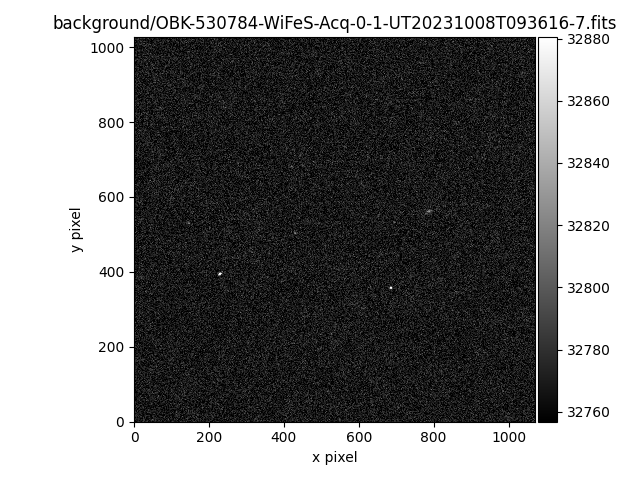

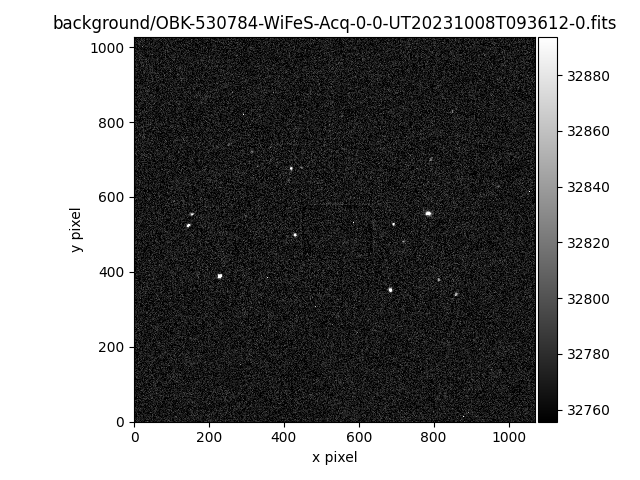

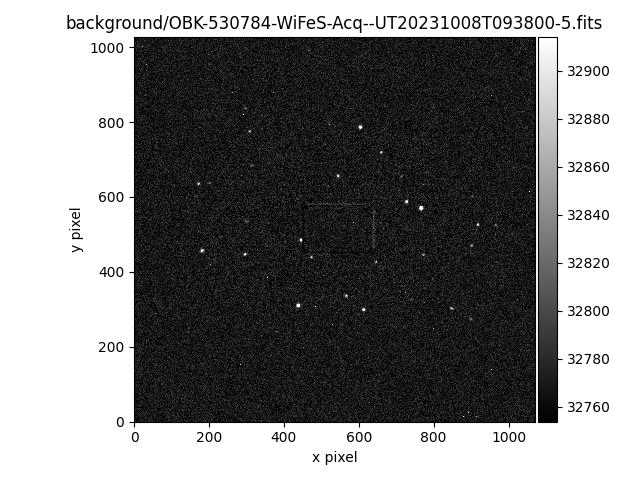

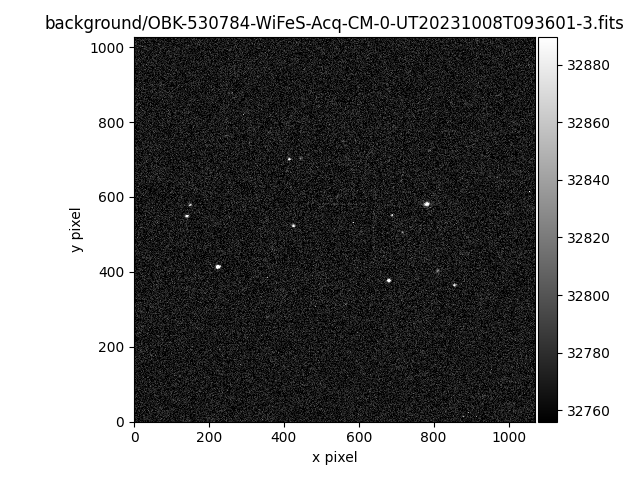

In [64]:
for file in os.listdir(OUTPUT_DIRS['BKG']):
    if file.endswith('.fits'):
        file = Fits(os.path.join(OUTPUT_DIRS['BKG'],file))
        file.image()

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq-0-0-UT20231008T093612-0.fits.segm
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      78   (1072, 1027)   int64 (rescales to float64)   


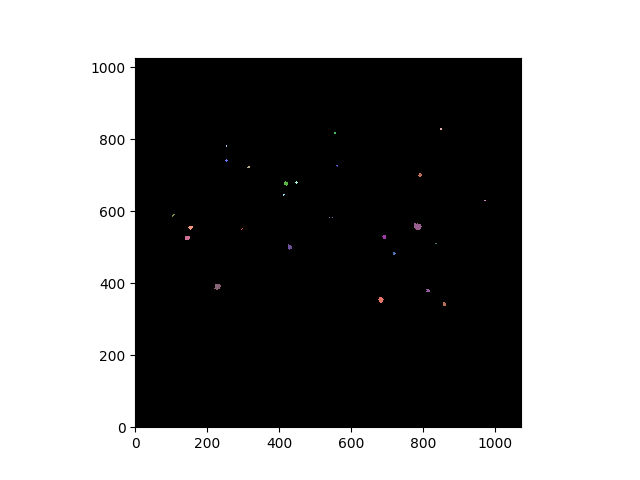

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq-CM-0-UT20231008T093601-3.fits.segm
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      78   (1072, 1027)   int64 (rescales to float64)   


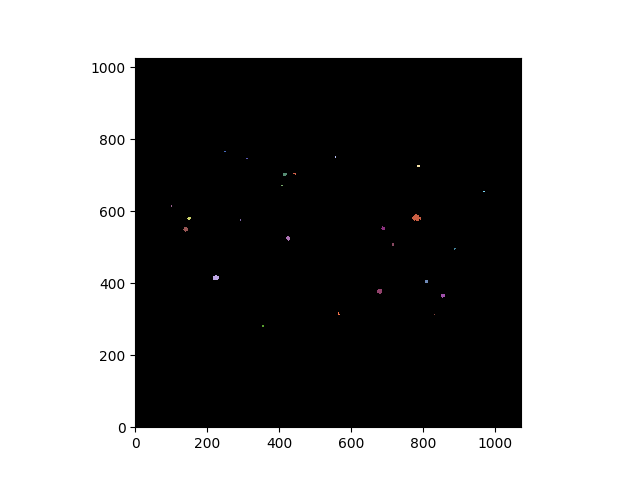

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.segm
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      79   (1072, 1027)   int64 (rescales to float64)   


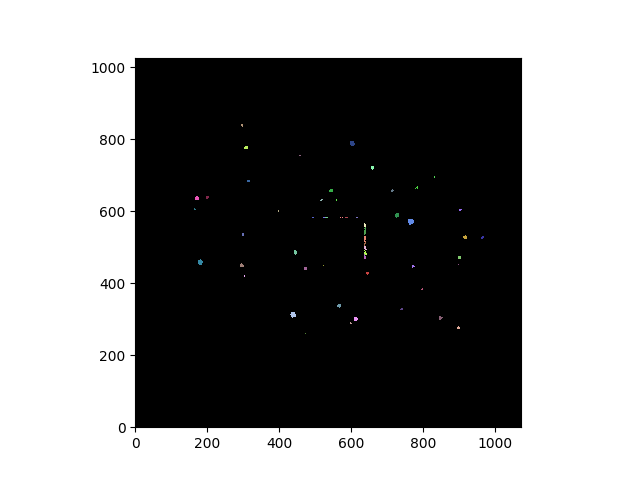

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq-0-1-UT20231008T093616-7.fits.segm
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      78   (1072, 1027)   int64 (rescales to float64)   


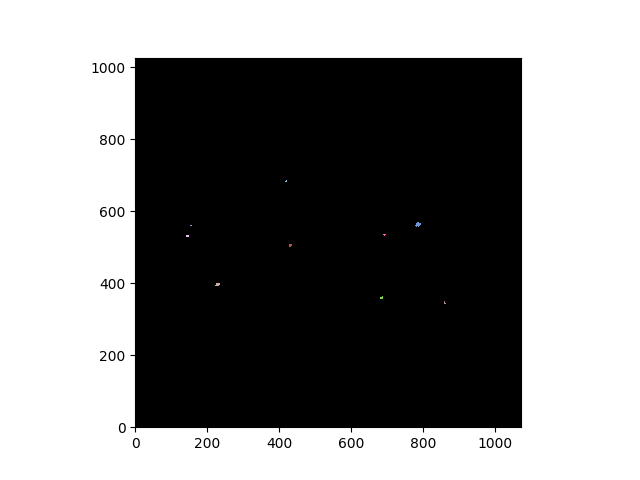

In [27]:
outdir = Path(OUTPUT_DIRS['DET'])
for file in os.listdir(outdir):
    if file.endswith('.segm'):
        segm = Fits(outdir.joinpath(file))
        cmap = load_object(outdir.joinpath(file+'.cmap.pkl'))
        plt.figure(clear=True)
        plt.imshow(segm.data[0], origin='lower', cmap=cmap,interpolation='nearest')
        plt.show()

In [52]:
load_object('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq--UT20231008T093800-5_sources.pkl').get_data()['kron_aperture'][0]

9.916381467479884

In [53]:
from astroquery.vizier import Vizier

In [94]:
catalog = Vizier()

In [99]:
tables = catalog.query_object('sirius',catalog='I/355/gaiadr3')

In [102]:
tables[0]

RA_ICRS,DE_ICRS,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RUWE,FG,e_FG,Gmag,FBP,e_FBP,BPmag,FRP,e_FRP,RPmag,BP-RP,RV,e_RV,Vbroad,GRVSmag,QSO,Gal,NSS,XPcont,XPsamp,RVS,EpochPh,EpochRV,MCMCGSP,MCMCMSC,And,Teff,logg,__Fe_H_,Dist,A0,HIP,PS1,SDSS13,SKYM2,TYC2,URAT1,AllWISE,APASS9,GSC23,RAVE5,_2MASS,RAVE6,RAJ2000,DEJ2000
deg,deg,,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,,,mag,,,mag,mag,km / s,km / s,km / s,mag,,,,,,,,,,,,K,log(cm.s**-2),,pc,mag,,,,,,,,,,,,,deg,deg
float64,float64,int64,float64,float64,float64,float32,float64,float64,float32,float64,float32,float64,float64,float32,float64,float32,float32,float64,float32,float32,float64,float64,float64,float32,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,float64,float64,float64,float64,float64,int32,int64,int64,int32,str12,str15,str19,int32,str10,str16,str17,str21,float64,float64
101.29264109428,-16.74746500884,2947050157291068928,20.7333,37.3749,--,--,--,--,--,--,--,--,122.75648,4.533,20.464756,--,--,--,--,--,--,--,--,--,--,--,0,0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,--,--,--,,,,--,,,,,101.29264109428,-16.74746500884
101.30841658134,-16.74029759782,2947050191653969792,3.4538,6.7303,--,--,--,--,--,--,--,--,716.55475,6.118,18.549244,5099,1150,16.069828,2320,396.9,16.334380,-0.264551,--,--,--,--,0,0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,--,--,--,,,,--,,,,,101.30841658134,-16.74029759782
101.30585400236,-16.73843681955,2947050191653970432,3.2775,6.3570,--,--,--,--,--,--,--,--,825.80121,6.941,18.395178,8292,995.6,15.541846,3264,439.2,15.963490,-0.421643,--,--,--,--,0,0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,87911013058254222,--,--,,,,--,,,,,101.30585400236,-16.73843681955
101.29751227495,-16.74425044166,2947050191653974400,0.1505,0.1529,0.5917,0.1062,1.597,1.406,0.222,0.758,0.199,1.037,3166.20170,16.49,16.936020,1.271e+04,1583,15.078155,6773,631,15.170942,-0.092788,--,--,--,--,0,0,0,1,0,0,0,0,0,1,0,--,--,--,--,--,--,87901012975037260,--,--,,,,--,,,,,101.29750574897,-16.74425380959
101.30903506763,-16.73977481430,2947050191656551296,8.0937,15.7373,--,--,--,--,--,--,--,--,239.98288,1.816,19.736916,--,--,--,--,--,--,--,--,--,--,--,0,0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,--,--,--,,,,--,,,,,101.30903506763,-16.73977481430
101.28893444726,-16.74596584258,2947050226010549760,34.0697,52.6458,--,--,--,--,--,--,--,--,115.18206,4.361,20.533905,1845,357.6,17.173616,717.3,174.7,17.608590,-0.434973,--,--,--,--,0,0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,--,--,--,,,,--,,,,,101.28893444726,-16.74596584258
101.29298121878,-16.73173035325,2947050260368847616,0.0397,0.0544,0.1680,0.0617,1.158,-0.002,0.054,1.158,0.065,1.051,8551.43167,42.23,15.857270,3.679e+04,2604,13.924350,2.271e+04,1287,13.857405,0.066945,--,--,--,--,0,0,0,1,0,0,0,0,0,1,0,--,--,--,--,--,--,87921012930072153,--,--,,,,--,,,,,101.29298122825,-16.73173550173
101.29363786986,-16.74053735100,2947050260368856448,13.0696,29.4794,--,--,--,--,--,--,--,--,504.44445,8.866,18.930334,9707,1156,15.370868,7050,1094,15.127412,0.243456,--,--,--,--,0,0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,--,--,--,,,,--,,,,,101.29363786986,-16.74053735100
